In [1]:
import math
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.getcwd()
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
# Use server_pull_updated
#from server_pull_updated import pull
from server_pull import pull

In [3]:
#Data from NUS server
# output = pull('user11','JdLuu9d0',arm) #arm refers to arm to pull. Need to include this in an array

In [4]:
#Initialize Variables

d = 24                  # number of possible combinations (here 24)
Ut_a = 0                # average reward of action 'a' prior to the time t. Initialized to zero
Nt_a = np.zeros(d)      # number of times action 'a' has been selected prior to time t
                        # If Nt(a) = 0, then a is considered to be a maximizing action.

sum_rewards = np.zeros(d) #cumulative sum of reward for a particular message
avg_rd_ucb_arm = np.zeros(d) # average reward from each arm for calculating regret

#helper variables to perform analysis
hist_t = [] #holds the natural log of each round
hist_achieved_rewards = [] #holds the history of the UCB CHOSEN cumulative rewards
hist_best_possible_rewards = [] #holds the history of OPTIMAL cumulative rewards
hist_random_choice_rewards = [] #holds the history of RANDONMLY selected actions rewards
###

In [5]:
def ucb(N):
    
    avg_reward_ucb = [] # for graph analysis
    R_ucb = [] # for graph analysis
    
    for t in range(0,N):
        UCB_Values = np.zeros(d) #array holding the ucb values. we pick the max  
        arm_selected = 0
    
        for a in range(0,d):
            if (Nt_a[a] > 0):
                ln_t = math.log(t) #natural log of t
                # hist_t.append(ln_t) #to plot natural log of t
            
                #calculate the UCB
                Ut_a = sum_rewards[a]/Nt_a[a]
                ucb_value = Ut_a + (ln_t/Nt_a[a])**(1/2)
                UCB_Values[a] = ucb_value
        
                #if this equals zero, choose as the maximum. Cant divide by negative     
            elif (Nt_a[a] == 0):
                UCB_Values[a] = 1e500 #make large value
        
        #select the max UCB value
        arm_selected = np.argmax(UCB_Values)
    
        #update Values as of round t
        Nt_a[arm_selected] += 1
        output = pull('user11','JdLuu9d0',arm_selected)
        reward = output['Reward']
        avg_rd_ucb_arm[arm_selected] = (avg_rd_ucb_arm[arm_selected] * ( Nt_a[arm_selected] - 1 ) + reward) / Nt_a[arm_selected]
    
        if t == 0:
            R_ucb.append(reward)
            avg_reward_ucb.append(reward)
        else:
            R_ucb.append(R_ucb[t-1] + reward)
            avg_reward_ucb.append((avg_reward_ucb[t-1] * (t-1) + reward)/t)
    
        sum_rewards[arm_selected] += reward
    
    return avg_reward_ucb, avg_rd_ucb_arm, R_ucb

In [6]:
#will call from each pull and update values

#Deciding number of rounds as
N = 1000
regret_i = np.linspace(0, N-1, N)

avg_reward_ucb, avg_rd_ucb_arm, R_ucb = ucb(N)

In [7]:
regret_ucb = pd.Series(index = regret_i, dtype = 'float64')

#best average reward
ba_reward = np.max(avg_rd_ucb_arm)

for i in range(N):
    regret_ucb[i] = ba_reward * (i+1) - R_ucb[i]

In [8]:
np.argmax(avg_rd_ucb_arm)

8

In [9]:
np.argmax(Nt_a)

8

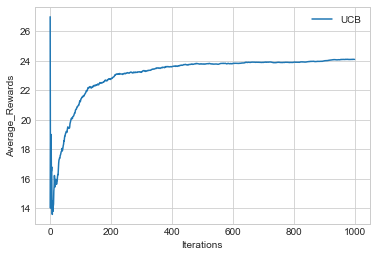

In [10]:
plt.plot(avg_reward_ucb, label = "UCB")
plt.xlabel("Iterations")
plt.ylabel("Average_Rewards")
plt.legend()
plt.show()

In [11]:
avg_rd_ucb_arm

array([22.34615385, 14.        , 21.66666667, 19.        ,  9.        ,
       18.        ,  2.        ,  9.        , 24.39872747,  8.        ,
       17.        , 16.        , 20.5       , 19.        , 20.8       ,
       11.        ,  9.        , 20.5       , 11.        , 20.5       ,
       11.        , 14.        , 18.        , 18.        ])

In [12]:
regret_ucb

0.0       -2.601273
1.0        7.797455
2.0        8.196182
3.0       13.594910
4.0       28.993637
            ...    
995.0    287.132556
996.0    290.531283
997.0    291.930011
998.0    293.328738
999.0    294.727466
Length: 1000, dtype: float64

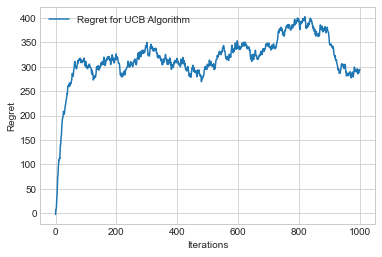

In [13]:
plt.plot(regret_ucb, label = "Regret for UCB Algorithm")
plt.xlabel("Iterations")
plt.ylabel("Regret")
plt.legend()
plt.show()

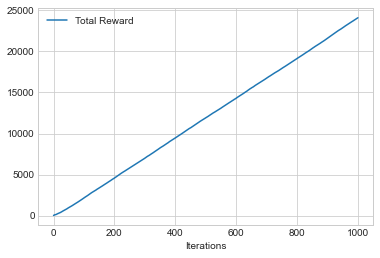

In [14]:
plt.plot(R_ucb, label = "Total Reward")
plt.xlabel("Iterations")
plt.legend()
plt.show()

In [15]:
np.argmax(Nt_a)

8

# Arm 8 is the most rewarding arm

In [16]:
def eps_greedy(N, eps):
    
    #Initialize reward and count for each arm
    avg_reward = np.zeros(24) #avg_reward value increased for each arm
    count = np.zeros(24) # count incremented when we collect reward from an arm
    
    #Decide whether the arm is to explore or exploit
    arm_explore = 0 #should take values from 0 to 24
    
    avg_reward_eps = pd.Series(index = rounds, dtype = 'float64') # for graph analysis
    R_eps = pd.Series(index = rounds, dtype = 'float64') # for graph analysis
    
    #enter loop to run epsilon_greedy
    for t in range(N):
        # if t is present in explore
        if t in explore:
            # Check value of arm_explore and collect reward from that arm and store in avg_reward
            output = pull('user11','JdLuu9d0',arm_explore)
            reward = output['Reward']
            count[arm_explore] += 1
            avg_reward[arm_explore] = ((avg_reward[arm_explore] * (count[arm_explore] - 1)) + reward)/count[arm_explore]

            if t == 0:
                R_eps[t] = reward
                avg_reward_eps[t] = reward
            else:
                R_eps[t] = R_eps[t-1] + reward
                avg_reward_eps[t] = (avg_reward_eps[t-1] * (t-1) + reward)/t

            if arm_explore == 23:
                arm_explore = 0
            else:
                arm_explore += 1 # next arm to explore

        # if i is present in exploit
        elif t in exploit:
            # Check for which arm the avg_reward is max and collect reward from that arm
            arm_exploit = np.argmax(avg_reward)
            output = pull('user11','JdLuu9d0',arm_exploit)
            reward = output['Reward']
            count[arm_exploit] += 1
            avg_reward[arm_exploit] = ((avg_reward[arm_exploit] * (count[arm_exploit] - 1)) + reward)/count[arm_exploit]
            R_eps[t] = R_eps[t-1] + reward
            avg_reward_eps[t] = (avg_reward_eps[t-1] * (t-1) + reward)/t
    
    return avg_reward_eps, avg_reward, R_eps

In [17]:
#Set epsilon value
eps = np.linspace(0.1, 0.5, 5) # 5 values for epsilon

#Deciding number of rounds as
N = 1000
regret_i = np.linspace(0, N-1, N)

rounds_exploit = np.arange(1,N)
rounds = np.arange(N)
arm_i = np.linspace(0,23,24)

avg_reward_e = pd.DataFrame(index = rounds, data = 0, columns = eps) # for graph analysis
avg_reward_arm = pd.DataFrame(index = arm_i, data = 0, columns = eps)
R_e = pd.DataFrame(index = rounds, data = 0, columns = eps) # for graph analysis
regret_eps = pd.DataFrame(index = regret_i, data = 0, columns = eps)

ba_reward = pd.DataFrame(index = ['best_arm', 'best_avg_arm'], columns = eps, data = 0) # best reward and arm for each epsilon value for regret

In [18]:
for e in eps:
    #Set indices that fall under exploit
    exploit = random.choices(rounds_exploit, k = int((1-e)*N)) #fill code. should contain (1-eps)*N values from 1 - 24

    #Set indices that fall under explore
    explore = list(set(rounds) - set(exploit)) #remaining values that dont fall under explore. should contain eps*N values from 0 - 24
    
    avg_reward_e[e], avg_reward_arm[e], R_e[e] = eps_greedy(N, e)
    
    #best average reward for each epsilon value
    ba_reward[e].iloc[0] = np.argmax(avg_reward_arm[e])
    ba_reward[e].iloc[1] = np.max(avg_reward_arm[e])

    for i in range(N):
        regret_eps[e].iloc[i] = ba_reward[e].iloc[1] * (i+1) - R_e[e].iloc[i]

C:\Users\navee\AppData\Local\Temp\ipykernel_36724\3467662311.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba_reward[e].iloc[0] = np.argmax(avg_reward_arm[e])
C:\Users\navee\AppData\Local\Temp\ipykernel_36724\3467662311.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba_reward[e].iloc[1] = np.max(avg_reward_arm[e])
C:\Users\navee\AppData\Local\Temp\ipykernel_36724\3467662311.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<Figure size 432x288 with 0 Axes>

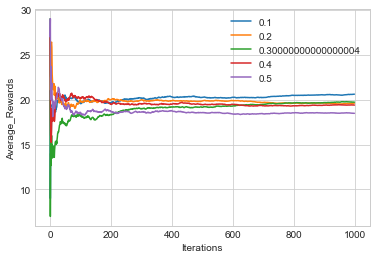

In [19]:
plt.figure()
avg_reward_e.plot()
plt.xlabel("Iterations")
plt.ylabel("Average_Rewards")
plt.show()

<Figure size 432x288 with 0 Axes>

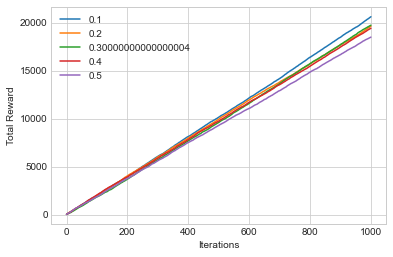

In [20]:
plt.figure()
# plt.plot(R_ucb, label = "Total Reward for UCB")
R_e.plot()
plt.xlabel("Iterations")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

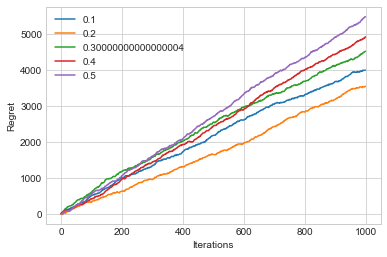

In [21]:
plt.plot(regret_eps, label = regret_eps.columns)
plt.xlabel("Iterations")
plt.ylabel("Regret")
plt.legend()
plt.show()

In [22]:
ba_reward

,0.1,0.2,0.3,0.4,0.5
best_arm,8.000000,0.000000,8.000000,8.000000,8.000000
best_avg_arm,24.607724,23.167266,24.255656,24.328571,23.977273


# Arm 8 is still the most rewarding arm

In [23]:
avg_reward_e

,0.1,0.2,0.3,0.4,0.5
0,21.000000,28.000000,29.000000,27.000000,27.000000
1,9.000000,23.000000,7.000000,20.000000,29.000000
2,14.500000,22.500000,14.000000,16.000000,20.000000
3,16.666667,24.333333,12.666667,16.000000,23.666667
4,16.250000,26.250000,14.250000,15.250000,21.250000
...,...,...,...,...,...
995,20.591960,19.612060,19.723618,19.395980,18.479397
996,20.594378,19.613454,19.722892,19.401606,18.479920
997,20.601805,19.605817,19.724173,19.409228,18.468405
998,20.601202,19.609218,19.718437,19.393788,18.473948


In [24]:
avg_reward_eps = avg_reward_e[0.1]

In [25]:
reg_eps = regret_eps[0.1] 

In [26]:
total_eps = R_e[0.1]

In [27]:
type(avg_reward_eps)

pandas.core.series.Series

### Comparison of Epsilon-greedy vs UCB1 for average rewards

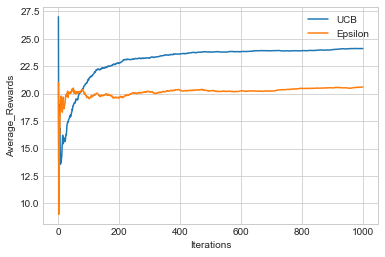

In [28]:
plt.plot(avg_reward_ucb, label = "UCB")
plt.plot(avg_reward_eps, label="Epsilon")
plt.xlabel("Iterations")
plt.ylabel("Average_Rewards")
plt.legend()
plt.show()

### Comparison of Epsilon-greedy vs UCB1 for regret

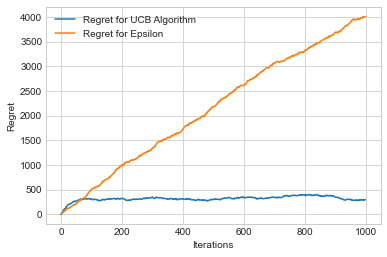

In [29]:
plt.plot(regret_ucb, label = "Regret for UCB Algorithm")
plt.plot(reg_eps, label = "Regret for Epsilon")
plt.xlabel("Iterations")
plt.ylabel("Regret")
plt.legend()
plt.show()

### Comparison for epsilon-greedy vs UCB1 for total rewards

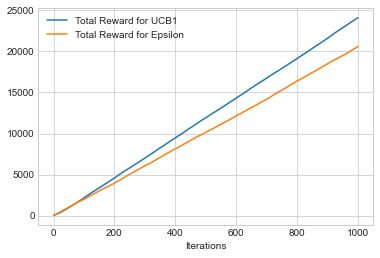

In [30]:
plt.plot(R_ucb, label = "Total Reward for UCB1")
plt.plot(total_eps, label="Total Reward for Epsilon")
plt.xlabel("Iterations")
plt.legend()
plt.show()